# Text Analytics in Python Using NLTK and Gensim

The purpose of this notebook is to show some Text Analytics strategies that you can use with the NLTK and Gensim packages in python. In addition, the notebook was written with a plug and play application is mind. What this means is that if you have another dataset that you want to use with this notebook, you only need to change a few code cells to run the same analysis (the csv file being read in, the name of the column that contains the reviews, and the word dictionaries if doing Rule Based Categorization). Below is the table of contents for this notebook. 

### Introduction
1. Reading in the Data

### Pre-analysis Definitions
1. Stemming
2. Lemmatization
3. Tokenization
4. Stop Words

### Data Preprocessing
1. Preparing data for tokenization
2. Tokenizing, Stemming/Lemmatizing, and Removing Stop Words
3. Word Frequencies
4. N-grams

### Topic Modelling with Gensim
1. Topic Modelling
2. Assigning Comments to Topics

### Rule Based Categorization
1. Creating Dictionaries
2. Tagging Comments

## Introduction

To show off the functionailty of NTLK and Gensim, we will use a sample Hotel's dataset from kaggle (https://www.kaggle.com/datafiniti/hotel-reviews/). It is a list of 1,000 hotels and their reviews provided by Datafiniti's Business Database. The dataset includes hotel location, name, rating, review data, title, and username, among other fields.  

### Reading in the Data

To start, we need to import the dictionaries we need and read in the dataset.

In [58]:
import pandas as pd
import string
import nltk
import warnings
import time
start = time.time()
warnings.filterwarnings('ignore')

data = pd.read_csv('Datafiniti_Hotel_Reviews.csv') 
data = data.dropna(subset=['reviews.text'])

To get a sense of what the reviews look like, we print out the first three comments in the dataset

In [59]:
print('Number of reviews: {}\n'.format(len(data)))
print('Example reviews: \n')
for i in data['reviews.text'].iloc[0:3]:
    print(i)
    print('\n')

Number of reviews: 9999

Example reviews: 

Our experience at Rancho Valencia was absolutely perfect from beginning to end!!!! We felt special and very happy during our stayed. I would come back in a heart beat!!!


Amazing place. Everyone was extremely warm and welcoming. We've stayed at some top notch places and this is definitely in our top 2. Great for a romantic getaway or take the kids along as we did. Had a couple stuffed animals waiting for our girls upon arrival. Can't wait to go back.


We booked a 3 night stay at Rancho Valencia to play some tennis, since it is one of the highest rated tennis resorts in America. This place is really over the top from a luxury standpoint and overall experience. The villas are really perfect, the staff is great, attention to details (includes fresh squeezed orange juice each morning), restaurants, bar and room service amazing, and the tennis program was really impressive as well. We will want to come back here again.




## Pre-Analysis Definitions

Before diving into the analysis, we must first define the following terms: **Stemming**, **Lemmatization**, and **Tokenization**

### Stemming

Stemming is the process by which a word is reduced to its word stem. The purpose of stemming (and also lemmatization) is to reduce a word to its core root. Reducing a word to its core root allows a text analytics algorithm to group words with similar meaning together in order to improve accuracy.

In ```NLTK```, there are multiple stemming algorithms available to use. For this notebook, we will be showing ```PorterStemmer``` and ```LancasterStemmer```. First, we define a stem object for both Porter and Lancaster stemming:

In [60]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

porter = PorterStemmer()
lancaster = LancasterStemmer()

Below is an example of how the ```PorterStemmer``` takes an example word, **stay**, and its various ending combinations, and simplifes them to the core word **stay**

In [61]:
print(porter.stem("stay"))
print(porter.stem("stayed"))
print(porter.stem("stays"))
print(porter.stem("staying"))

stay
stay
stay
stay


The ```PorterStemmer``` is known for it's speed and simplicity, and is typically used in Information Retrieval Environments where fast recall and fetching of search queries is important. On the other hand, the Lancaster stemmer is more aggressive in stemming words.

In [62]:
print(porter.stem("destabilized"))
print(porter.stem("destabilize"))
print(porter.stem("destabilizing"))
print(porter.stem("destabilizes"))

destabil
destabil
destabil
destabil


Lancaster here stems the word destabilize to **dest**

In [63]:
print('Lancaster Stemming Example with "destabilize"')
print('destabilized --> {}'.format(lancaster.stem("destabilized")))
print('destabilize --> {}'.format(lancaster.stem("destabilize")))
print('destabilizing --> {}'.format(lancaster.stem("destabilizing")))
print('destabilizes --> {}'.format(lancaster.stem("destabilizes")))

Lancaster Stemming Example with "destabilize"
destabilized --> dest
destabilize --> dest
destabilizing --> dest
destabilizes --> dest


The **PorterStemmer** and **LancasterStemmer** has disadvantages, namely that 

1. The words sometimes do not stem to actual words
2. Linguistic meaning can sometimes be lost

The example below with **university** and **universe** illustrates this point

In [64]:
print(porter.stem("university"))
print(porter.stem("universal"))
print(porter.stem("universities"))
print(porter.stem("universe"))

univers
univers
univers
univers


In [65]:
print(lancaster.stem("university"))
print(lancaster.stem("universal"))
print(lancaster.stem("universities"))
print(lancaster.stem("universe"))

univers
univers
univers
univers


As you can see above, the words university and universe simplify to *univers*, and difference in meaning between the two words is lost. One way to remedy this problem is with Lemmatization 

### Lemmatization

Sometimes, instead of getting the stem of a word, which might not be an actual word, we can lemmetize our words to make sure that the words are grouped into an actual language word. Whereas the word **"pictures"** might stem to something like **"pictur"**, in lemmatization it would shorten to **"picture"**. This grouping is useful for keeping the full linguistic context of a word as opposed to just keeping the root of a word.

In the ```NLTK``` package we can use ```WordNetLemmatizer``` to lemmatize our words

In [66]:
from nltk.stem import WordNetLemmatizer   
lemmatizer = WordNetLemmatizer() 

Going back to the example of university and universe, we see that Lemmatization ensures that we retain linguistic meaning while still grouping words where possible

In [67]:
print(lemmatizer.lemmatize("university"))
print(lemmatizer.lemmatize("universal"))
print(lemmatizer.lemmatize("universities"))
print(lemmatizer.lemmatize("universe"))

university
universal
university
universe


So how do we decide which strategy to use when grouping similar words? When is stemming more advantagous to use when compared with lemmatization? The answer depends your application, and the importance of retaining linguistic meaning vs. having more simplified word groupings and reducing the number of features in your algorithm. If you cut off too much of the ending of a word (**overstemming**) you may have more nonsensical terms in your output and/or lose linguistic meaning. If you cut off too little from the ending of a word (**understemming**), then you may not be grouping enough similar words together and thus open your model up to potential overfitting.

### Tokenization

*What is tokenization?*
* Tokenization is when you take a string of text, and make each word an item in a list so each word can be analyzed individually
* **EXAMPLE:** ```"Our experience at Rancho Valencia was absolutely perfect from beginning to end!!!!" --> ['our','experience','at','rancho','valencia','was', 'absolutely','perfect','from', 'beginning', 'to', 'end']```

*Why do we use tokenization?*
* It is the general format used for many text analysis techniques in NTLK, including Frequency Distribution and  N-Grams, among other techniques

In ```NTLK```, you can tokenize a string of text using ```word_tokenize```

In [68]:
sample_string = 'Our experience at Rancho Valencia was absolutely perfect from beginning to end'
sample_token = nltk.word_tokenize(sample_string.lower())

print('Raw Comment: "Our experience at Rancho Valencia was absolutely perfect from beginning to end"')
print('Cleaned Comment: {}'.format(sample_token))

Raw Comment: "Our experience at Rancho Valencia was absolutely perfect from beginning to end"
Cleaned Comment: ['our', 'experience', 'at', 'rancho', 'valencia', 'was', 'absolutely', 'perfect', 'from', 'beginning', 'to', 'end']


### Stop Words

One issue that adds a lot of noise to a text analytics model are common words that appear in many comments but often add little contextual meaning. Examples of common words are "the", "at", "a", "an". These words are known as **stop words**. Fortunately, ```NTLK``` has a pre-defined corpus of stop words, ```nltk.corpus.stopwords.words('english')```, which you can you to filter out these common words from your text data. Below is a subset of words within the ```NLTK``` stop words corpus

In [69]:
print('First 10 stop words in the NLTK Stop Words Corpus (English):')
print(nltk.corpus.stopwords.words('english')[0:10])

First 10 stop words in the NLTK Stop Words Corpus (English):
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


Here is an example of applying ```nltk.corpus.stopwords.words('english')``` to your tokenized text

In [70]:
sample_string = 'Our experience at Rancho Valencia was absolutely perfect from beginning to end'
sample_token = nltk.word_tokenize(sample_string.lower())   # <----- Original Tokenized Text

stop_words = nltk.corpus.stopwords.words('english')
sample_token_no_stop = [word for word in sample_token if word not in stop_words] # <-- Removing Stop Words

print('Raw Comment: "Our experience at Rancho Valencia was absolutely perfect from beginning to end"')
print('Tokenized Comment: {}'.format(sample_token))
print('Tokenized Comment After Removing Stop Words: {}'.format(sample_token_no_stop))

Raw Comment: "Our experience at Rancho Valencia was absolutely perfect from beginning to end"
Tokenized Comment: ['our', 'experience', 'at', 'rancho', 'valencia', 'was', 'absolutely', 'perfect', 'from', 'beginning', 'to', 'end']
Tokenized Comment After Removing Stop Words: ['experience', 'rancho', 'valencia', 'absolutely', 'perfect', 'beginning', 'end']


## Data Preprocessing

Now that we have some NLP preprocessing techniques defined, let's use them in practice on a real dataset

### Preparing the Reviews for Tokenization

The first step in the analysis to clean up the reviews so that they can be easily tokenized. There are two parts of the review that need to be cleaned:

1. Remove punctuation
2. Expand contraction words (i.e. don't --> do not)

#### Removing Punctuation

To remove punctuation, we define a function, ```remove_punctuation```, that utilizes the ```string``` library to look for and remove any symbols related to punctuation, with the exception of apostrophes (needed for expanding contraction words). The ```string``` library is a default library in Python

In [71]:
def remove_punctuation(text):
    nopunc = []
    # Looks for and removes punctuations from string
    for char in text:
        if char == '’' or char == "'":
            nopunc.append("'")
        # Punctuation in string.punctuation: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        elif char in string.punctuation and char != "'":
            nopunc.append(' ')
        else:
            nopunc.append(char)
    # After removing punctuation, join string back together
    output = ''.join(nopunc)
    
    return output

sample_sentence_one = 'here: a sentence - alibeit convoluted - with lots(!) of random $%^ punctuation?'

print('Raw Comment: {}'.format(sample_sentence_one))
print('Cleaned Comment: {}'.format(remove_punctuation(sample_sentence_one)))

Raw Comment: here: a sentence - alibeit convoluted - with lots(!) of random $%^ punctuation?
Cleaned Comment: here  a sentence   alibeit convoluted   with lots    of random     punctuation 


#### Expanding Contraction Words

To expand contraction words, we must first define a mapping of a contraction word to its expanded form. Fortunately, someone on the internet has already done this (https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python). To avoid adding extra space to this notebook, the dictionary of contraction word mappings was placed in ```contractions_v2.py```, then called into this notebook using ```import```. The code cell below shows how the contraction word mappings are brought into the notebook, as well as a print of 10 terms within the contraction word mapping dictionary 

In [72]:
# Get a dictionary of english language contractions
from contractions_v2 import get_word_contractions
contract_list = get_word_contractions()

print('Example of items in the contraction word list dictionary:')
dict(list(contract_list.items())[0:10])

Example of items in the contraction word list dictionary:


{"'cause": 'because',
 "ain't": 'am not',
 "aren't": 'are not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not'}

Now that the mapping has been added, we can define a function, ```expand_contraction_words```, that looks at each word in the review and expands a contraction word if it exists.

In [73]:
def expand_contraction_words(lst, contraction_list):
    final_output = []
    for item in lst:
        if item.lower() in contraction_list.keys():
            final_output.append(contraction_list[item.lower()])
        else:
            final_output.append(item)
            
    return final_output
            
print('Example input/output of expand_contraction_words function:')
print('Input: {}'.format(["we", "aren't", "he", "didn't", "she", "wouldn't"]))
print('Output: {}'.format(expand_contraction_words(["we", "aren't", "he", "didn't", "she", "wouldn't"], contract_list)))

Example input/output of expand_contraction_words function:
Input: ['we', "aren't", 'he', "didn't", 'she', "wouldn't"]
Output: ['we', 'are not', 'he', 'did not', 'she', 'would not']


Putting the ```remove_punctuation``` and ```expand_contraction_words``` functions together, we can define a new function, ```clean_review``` which takes a review with punctuations and contraction words and returns a review with punctuation removed, and contraction words expanded.

In [74]:
# Function that removes punctuation and expands contraction words
def clean_review(text, contraction_list):
    # Remove Punctuation
    nopunc = remove_punctuation(text).split(' ')
    
    # Expand contraction words
    final_output = expand_contraction_words(nopunc, contraction_list)
            
    return ' '.join(final_output).lower()

sample_sentence_two = "WHOA! I DON'T THINK SENTENCE(?) is cleaned*...or maybe it's clean NOW"

print('Here is an example of a cleaned comment:')
print('Raw Comment: {}'.format(sample_sentence_two))
print('Cleaned Comment: {}'.format(clean_review(sample_sentence_two, contract_list)))

Here is an example of a cleaned comment:
Raw Comment: WHOA! I DON'T THINK SENTENCE(?) is cleaned*...or maybe it's clean NOW
Cleaned Comment: whoa  i do not think sentence    is cleaned    or maybe it is clean now


### Tokenizing, Stemming/Lemmatizing, and Removing Stop Words

Next, we get the reviews in a format that can be used for text analysis. This step involves removing stopwords, tokenizing the review, and stemming / lemmatizing words within the review. The function below does all of the above steps. 

In [75]:
def tokenize(text, stemmer=None):
    stop_words = set([i for i in nltk.corpus.stopwords.words('english') if i not in ['no','not']])
    tokenized_text = nltk.word_tokenize(text)
    
    if stemmer == None:
        return [word for word in tokenized_text if word not in stop_words]
    elif stemmer == 'Porter':
        return [porter.stem(word) for word in tokenized_text if word not in stop_words]
    elif stemmer == 'Lancaster':
        return [lancaster.stem(word) for word in tokenized_text if word not in stop_words]
    elif stemmer == 'Lemmatize':
        return [lemmatizer.lemmatize(word) for word in tokenized_text if word not in stop_words]

The code cell below applies the above function to the dataset, and puts all reviews together in list of lists (i.e. a corpus of reviews). As an example, there is a variable defined below for each potential stemming/lemmatizing scenario discussed (No Stemming/Lemmatization, Porter, Lancaster, and Lemmatize). However, **moving forward in this notebook, we will use the scenario where all reviews are Lemmatized (i.e. corp_lemma)**

In [76]:
corp_norm = [tokenize(clean_review(comment, contract_list)) for comment in data['reviews.text']]
corp_lancaster = [tokenize(clean_review(comment, contract_list), stemmer='Lancaster') for comment in data['reviews.text']]
corp_lemma = [tokenize(clean_review(comment, contract_list), stemmer='Lemmatize') for comment in data['reviews.text']]
corp_porter = [tokenize(clean_review(comment, contract_list), stemmer='Porter') for comment in data['reviews.text']]

### Word Frequencies

Now that our comments are tokenized, we can start to use more functionality within ```NLTK```. The first function to show is ```FreqDist```, which can allow you to see the most common words within the reviews. To do this, we must first flatten out the corpus of reviews (go from list of lists to one long list with all the words from all the reviews). Then we can use ```FreqDist``` and ```plot``` to show the words with the highest frequency. In addition to the plot, we can do some additional processing to get the word frequencies in a tabular (DataFrame) format.

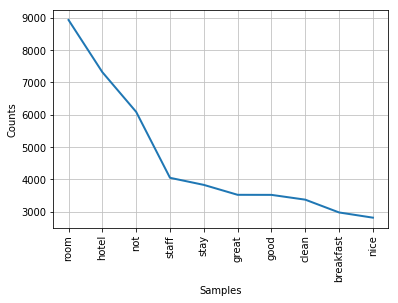

,word,frequency
70,room,8928
122,hotel,7314
39,not,6085
59,staff,4046
45,stay,3827
26,great,3520
202,good,3518
150,clean,3370
143,breakfast,2974
156,nice,2813


In [77]:
# Use NLTK FreqDist to get the most common words in the review
word_frequency = nltk.FreqDist([item for sublist in corp_lemma for item in sublist])
word_frequency.plot(10)

word_frequency_df = pd.DataFrame.from_dict(word_frequency, orient='index', columns=['frequency'])
word_frequency_df.reset_index(level=0, inplace=True)
word_frequency_df = word_frequency_df.rename(columns={'index': 'word'})
word_frequency_df.sort_values(by=['frequency'], ascending=False).iloc[0:10]

### N-Grams

N-Grams refers to the  “contiguous sequence of N items from a given sample of text or speech”. The frequency distribution shown above is an example of **unigrams** or 1-grams. ```NLTK``` allows you to look at as many continuous sequence lengths as desired given tokenized text data and the function ```ngrams```. Below are examples of what 2-grams (or **bigrams**) and 3-grams (or **tri-grams**) look like:

In [78]:
from nltk.util import ngrams

print('Tokenized Comment: {}'.format(corp_lemma[0]))

corp_lemma_bigrams = [tuple(ngrams(comment, 2)) for comment in corp_lemma]
print('Example Bigrams: {}'.format(corp_lemma_bigrams[0]))

corp_lemma_trigrams = [tuple(ngrams(comment, 3)) for comment in corp_lemma]
print('Example Trigrams: {}'.format(corp_lemma_trigrams[0]))

Tokenized Comment: ['experience', 'rancho', 'valencia', 'absolutely', 'perfect', 'beginning', 'end', 'felt', 'special', 'happy', 'stayed', 'would', 'come', 'back', 'heart', 'beat']
Example Bigrams: (('experience', 'rancho'), ('rancho', 'valencia'), ('valencia', 'absolutely'), ('absolutely', 'perfect'), ('perfect', 'beginning'), ('beginning', 'end'), ('end', 'felt'), ('felt', 'special'), ('special', 'happy'), ('happy', 'stayed'), ('stayed', 'would'), ('would', 'come'), ('come', 'back'), ('back', 'heart'), ('heart', 'beat'))
Example Trigrams: (('experience', 'rancho', 'valencia'), ('rancho', 'valencia', 'absolutely'), ('valencia', 'absolutely', 'perfect'), ('absolutely', 'perfect', 'beginning'), ('perfect', 'beginning', 'end'), ('beginning', 'end', 'felt'), ('end', 'felt', 'special'), ('felt', 'special', 'happy'), ('special', 'happy', 'stayed'), ('happy', 'stayed', 'would'), ('stayed', 'would', 'come'), ('would', 'come', 'back'), ('come', 'back', 'heart'), ('back', 'heart', 'beat'))


We can also still use the ```FreqDist``` function in ```NLTK``` to see the frequency of particular bigrams or trigrams within our corpus of text data:

Bigrams Frequency Distribution


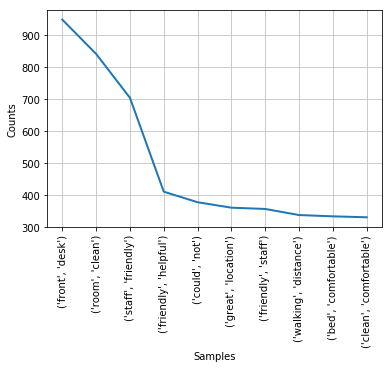

In [79]:
print('Bigrams Frequency Distribution')
nltk.FreqDist([item for sublist in corp_lemma_bigrams for item in sublist]).plot(10)

Trigrams Frequency Distribution


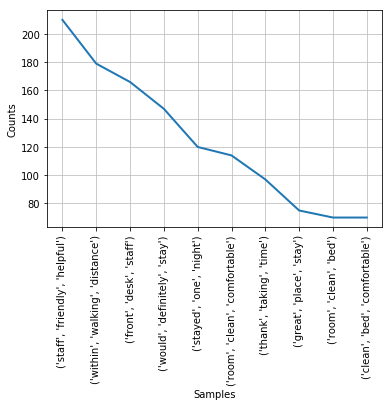

In [80]:
print('Trigrams Frequency Distribution')
nltk.FreqDist([item for sublist in corp_lemma_trigrams for item in sublist]).plot(10)

#### Skipgrams

One variation on N-grams are **skipgrams**. Skipgrams are similar to N-grams in that you are looking for items in your text that are of the same number of words (i.e. for bigrams, all items were two word pairs). However, the key difference is that you are allowed to "skip" words that appear in between. Skipgrams gets all N-word combinations of a review given the allowed number of words you can skip. Note that for skipgrams you need at least a two-gram (because there are no words between a single word!). Here is an example to better illustrate what skipgrams does.   

In [81]:
from nltk.util import skipgrams

sample_text = ['hello', 'welcome', 'informs', 'meetup', 'something', 'nltk']
bigram_sample = list(ngrams(sample_text, 2))
bigram_skip_sample = list(skipgrams(sample_text, 2, 2))

print('Tokenized comment: {}'.format(sample_text))
print('Example Bigrams: {}'.format(bigram_sample))
print('Example Trigrams with 2 word skip: {}'.format(bigram_skip_sample))

Tokenized comment: ['hello', 'welcome', 'informs', 'meetup', 'something', 'nltk']
Example Bigrams: [('hello', 'welcome'), ('welcome', 'informs'), ('informs', 'meetup'), ('meetup', 'something'), ('something', 'nltk')]
Example Trigrams with 2 word skip: [('hello', 'welcome'), ('hello', 'informs'), ('hello', 'meetup'), ('welcome', 'informs'), ('welcome', 'meetup'), ('welcome', 'something'), ('informs', 'meetup'), ('informs', 'something'), ('informs', 'nltk'), ('meetup', 'something'), ('meetup', 'nltk'), ('something', 'nltk')]


Notice that the number of "grams" in your list will grow exponentially as your N or number of allowed skips between words increases. Here is an example from our dataset when looking at trigrams and allowed 3 word skip:

In [82]:
print('Tokenized Comment (length {}): {}'.format(len(corp_lemma[0]), corp_lemma[0]))
print('Example Trigrams (length {}): {}'.format(len(corp_lemma_trigrams[0]), corp_lemma_trigrams[0]))

corp_lemma_skipgrams = [tuple(skipgrams(comment, 3, 3)) for comment in corp_lemma]
print('\nExample Trigrams with allowed 3 word skip (length {}):\n {}'.format(len(corp_lemma_skipgrams[0]), corp_lemma_skipgrams[0]))

Tokenized Comment (length 16): ['experience', 'rancho', 'valencia', 'absolutely', 'perfect', 'beginning', 'end', 'felt', 'special', 'happy', 'stayed', 'would', 'come', 'back', 'heart', 'beat']
Example Trigrams (length 14): (('experience', 'rancho', 'valencia'), ('rancho', 'valencia', 'absolutely'), ('valencia', 'absolutely', 'perfect'), ('absolutely', 'perfect', 'beginning'), ('perfect', 'beginning', 'end'), ('beginning', 'end', 'felt'), ('end', 'felt', 'special'), ('felt', 'special', 'happy'), ('special', 'happy', 'stayed'), ('happy', 'stayed', 'would'), ('stayed', 'would', 'come'), ('would', 'come', 'back'), ('come', 'back', 'heart'), ('back', 'heart', 'beat'))

Example Trigrams with allowed 3 word skip (length 120):
 (('experience', 'rancho', 'valencia'), ('experience', 'rancho', 'absolutely'), ('experience', 'rancho', 'perfect'), ('experience', 'rancho', 'beginning'), ('experience', 'valencia', 'absolutely'), ('experience', 'valencia', 'perfect'), ('experience', 'valencia', 'beginn

Like with N-grams, you can also use ```FreqDist``` with skipgrams

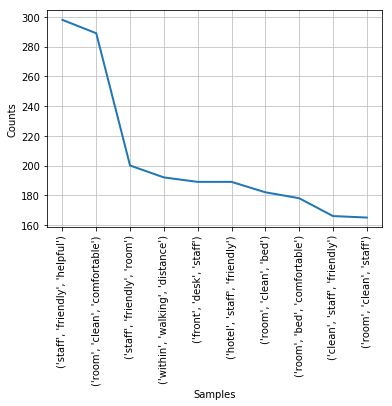

In [83]:
nltk.FreqDist([item for sublist in corp_lemma_skipgrams for item in sublist]).plot(10)

## Topic Modelling with Gensim

After all the definitions and data processing work, we can finally get to our model! 

### Topic Modelling

For topic modelling, we can use the package ```gensim```, which does topic modelling using a technique called Latent Dirichlet Allocation (https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). At a high level, Latent Dirichlet Allocation is a statistical model that assigns probabilities of words being in a topic based on words in the review itself and words in all of the reviews. 

To get started with topic modelling, we first have to create corpus objects within Gensim so that it can run the analysis. To do this, we use the one of the corpus list of lists we defined earlier in the notebook. For the purposes of the analysis, we will use the ```corp_lemma``` variable as our corpus 

In [84]:
from gensim import corpora
dictionary = corpora.Dictionary(corp_norm)
corpus = [dictionary.doc2bow(text) for text in corp_norm]

Next, we will save the corpus in a format that can be used for a later visualization of results. To do this, we use the ```pickle``` package in python, which allows you to serialize or deserialize a Python object for later use (for more information on pickle, see the appendix).

In [85]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

Next, we define the number of topics we want the model to output, set parameters for the model, and run the model using the corpus and dictionary variables defined above.

In [86]:
import gensim
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS,
                                           id2word=dictionary, passes=20, random_state=12)
ldamodel.save('model.gensim')

Unfortunately, there is no set way to decide how to choose the number of topics. This part of the analysis is where domain knowledge and trial-and-error come into play. One way in ```gensim``` to interpret the topic modelling results is to print out the highest probability words within each topic

In [87]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.012*"la" + 0.008*"lodge" + 0.008*"u" + 0.007*"en" + 0.007*"curtains"')
(1, '0.047*"not" + 0.041*"room" + 0.016*"hotel" + 0.012*"no" + 0.011*"night"')
(2, '0.014*"place" + 0.007*"best" + 0.006*"virginia" + 0.006*"years" + 0.006*"santa"')
(3, '0.041*"room" + 0.019*"bed" + 0.017*"clean" + 0.016*"nice" + 0.014*"no"')
(4, '0.038*"good" + 0.037*"hotel" + 0.037*"clean" + 0.037*"staff" + 0.032*"great"')
(5, '0.022*"„" + 0.014*"aria" + 0.010*"anaheim" + 0.008*"stadium" + 0.006*"hotel"')
(6, '0.021*"not" + 0.020*"staff" + 0.020*"hotel" + 0.018*"breakfast" + 0.014*"room"')
(7, '0.029*"thank" + 0.017*"us" + 0.015*"service" + 0.014*"hotel" + 0.013*"review"')
(8, '0.023*"stayed" + 0.021*"inn" + 0.015*"stay" + 0.015*"hotel" + 0.015*"staff"')
(9, '0.027*"hotel" + 0.018*"great" + 0.013*"not" + 0.010*"stay" + 0.010*"pool"')


Another handy way to interpret the topic modelling results is by utilizing ```pyLDAvis```, a topic modelling visualization package that is supplemental to ```gensim```.  The ```pyLDAvis``` package takes the results from your gensim model to create the visualization.

In [88]:
# Use pyLDA to visualize topics
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model.gensim')

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)

Below is a visualization of the topic modeling results. The visualization has several helpful features to understand the topics generated by the model.

1. On the left side, there is a distance map that shows how close in similarity each topic is relative to one another, as well as the size of the topic relative to the entire corpus of comments
2. Based on the topic you hover over/select on the left side, the right side updates with a bar chart of the top 30 words within that topic. The bar chart has a blue bar that shows the overall term frequency, and a red bar that shows the estimated term frequency within the selected topic. 
    a. Note that when no topic is selected, the bar chart on the right only shows overall term frequencies
3. On the top right, there is a slider that can be used to adjust how much weight the visualization places on how relevent a given word is to the selected topic vs. the overall term frequency. A lower value of $\lambda$ means that more weight is placed on the topic relevancy of words. For example, if a word in the topic only appears in the selected topic, it will be given more weight over a word that appears with a high frequency in the corpus. 

In [92]:
pyLDAvis.display(lda_display)

### Assigning Comments to Topics

Based on the visualization, the topics generated become a lot more clear. Now, to finish off the algorithm, we want to label the topics and map them to each comment.

In [122]:
# Example of labelling topics for the Hotel sample dataset

# Define your topic categories based on topic model analysis above
topic_cats = {0:'Spanish Reviews',
              1:'Dirty/Noisy Room',
              2:'Location',
              3:'Room Utilities',
              4:'Good Experience',
              5:'Anaheim Stadium',
              6:'Front Desk',
              7:'Thank You',
              8:'Hotel Stay',
              9:'Scenery'}


# Get topic numbers from LDA model for each review
corpus_topics = list(ldamodel.get_document_topics(corpus))


# Map topic label numbers to topic category names
topic_labels = []
for comment in corpus_topics:
    probs = {k:v for k, v in comment}
    best_topic = max(probs, key=lambda key: probs[key])
    topic_labels.append(topic_cats[best_topic])

Finally, we add a column for the topic labels to the dataset. 

In [131]:
# Add topic label column to dataset
data['topic'] = topic_labels

pd.set_option('max_colwidth', 120)
display(data[['reviews.text', 'topic']].head(10))

,reviews.text,topic
0,Our experience at Rancho Valencia was absolutely perfect from beginning to end!!!! We felt special and very happy du...,Scenery
1,Amazing place. Everyone was extremely warm and welcoming. We've stayed at some top notch places and this is definite...,Front Desk
2,"We booked a 3 night stay at Rancho Valencia to play some tennis, since it is one of the highest rated tennis resorts...",Scenery
3,Currently in bed writing this for the past hr 1/2 there have been dogs barking and squealing call the front desk to ...,Dirty/Noisy Room
4,I live in Md and the Aloft is my Home away from home...we stayed 1 night 7-7-16 ...Staff is great ! Especially Olivi...,Hotel Stay
5,"I stayed here with my family for my daughters wedding. It had a very accommodating staff, Olivia was excellent. The ...",Hotel Stay
6,"Beautiful rooms and the nicest people working there. The front desk lady, Olivia, was extremely patient and helpful....",Front Desk
7,"We stayed here while visiting Maryland Live!. Cute hotel in a great location. Clean, with a very modern look, upgrad...",Good Experience
8,"I travel a lot with my job, so I'm constantly staying at hotels. When my co-workers and I arrived late last night at...",Front Desk
9,"In my line of work, I use meeting space in hotels often. In my 15+ years of doing this work, this is the first time ...",Dirty/Noisy Room


## Rule Based Categorization

Create dictionaries to categorize reviews

In [90]:
# Tag Dictionaries

good_experience = ['great', 'nice', 'good', 'awesome', 'wonderful', 'amazing', 'perfect']

food = ['food', 'breakfast', 'lunch', 'dinner']

front_desk = [('front', 'desk')]

walking_distance = [('within', 'walking', 'distance')]

Loop through each comment and tag a comment if it contains a word in one of the dictionaries

In [91]:
print('Done.')
print('Runtime: {}'.format(time.time()-start))

Done.
Runtime: 661.9216980934143


## Appendix

### Sources:

NLTK Online Textbook
1. http://www.nltk.org/book/

Stemming and Lemmatization 
1. https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8
2. https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
3. https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

Topic Modelling with Gensm
1. https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

Pickle
1. https://docs.python.org/3/library/pickle.html
2. https://www.geeksforgeeks.org/understanding-python-pickling-example/

pyLDAvis
1. https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf